# Chapter 9 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from scipy import stats
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Constants

In [2]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"
RUGGED_FILE = "rugged.csv"
TULIPS_FILE = "tulips.csv"

RANDOM_SEED = 42

### Defaults

In [3]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

# set seed
rng = np.random.default_rng(RANDOM_SEED)

### Functions

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

In [5]:
def smooth_plot_data(x, y, smooth_kwargs=None):
    if smooth_kwargs is None:
        smooth_kwargs = {}

    smooth_kwargs.setdefault("window_length", 55)
    smooth_kwargs.setdefault("polyorder", 2)
    x_data = np.linspace(x.min(), x.max(), 200)
    x_data[0] = (x_data[0] + x_data[1]) / 2
    y_interp = griddata(x, y, x_data)
    y_data = savgol_filter(y_interp, axis=0, **smooth_kwargs)

    return x_data, y_data

## 9.4 Easy HMC: `ulam`

Let's revisit the rugged interaction model from chapter 8

In [6]:
# load the data
rugged = load_data(RUGGED_FILE, delimiter=";")

# define log gdp
rugged["log_gdp"] = np.log(rugged["rgdppc_2000"])

# restrict to countries with gdp data
rugged = rugged.dropna(subset=["rgdppc_2000"])

# standardise variables
rugged["log_gdp_std"] = rugged["log_gdp"] / rugged["log_gdp"].mean()
rugged["rugged_std"] = rugged["rugged"] / rugged["rugged"].max()

# set up index variables
continents = [
    "Not Africa",
    "Africa",
]
rugged["continent"] = np.where(
    rugged["cont_africa"] == 1,
    "Africa",
    "Not Africa",
)
continents_idx_mapper = {
    "Not Africa": 0,
    "Africa": 1,
}

In [7]:
coords = {
    "country": rugged.country,
    "continent": continents,
}
with pm.Model(coords_mutable=coords) as m9_1:
    # data
    rugged_std = pm.MutableData("rugged_std", rugged.rugged_std, dims="country")
    rugged_std_mean = pm.MutableData("rugged_std_mean", rugged.rugged_std.mean())
    continent_idx = pm.MutableData("continent_idx", rugged.cont_africa, dims="country")

    # priors
    alpha = pm.Normal("alpha", mu=1, sigma=0.1, dims="continent")
    beta = pm.Normal("beta", mu=0, sigma=0.3, dims="continent")
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu",
        alpha[continent_idx] + beta[continent_idx] * (rugged_std - rugged_std_mean),
        dims="country",
    )

    # likelihood
    log_gdp_std = pm.Normal(
        "log_gdp_std", mu=mu, sigma=sigma, observed=rugged.log_gdp_std, dims="country"
    )

    # sample
    trace_9_1 = pm.sample(
        chains=1,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
az.summary(
    trace_9_1,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Not Africa],1.05,0.01,1.03,1.07,0.0,0.0,2071.14,875.94,NaN
alpha[Africa],0.89,0.02,0.86,0.91,0.0,0.0,1599.71,799.33,NaN
beta[Not Africa],-0.14,0.06,-0.24,-0.05,0.0,0.0,1338.52,850.21,NaN
beta[Africa],0.13,0.08,0.02,0.26,0.0,0.0,1538.07,767.47,NaN
sigma,0.11,0.01,0.10,0.12,0.0,0.0,1005.26,761.67,NaN


`ess` stands for effective sample size.
`ess_bulk` can be considered equivalent to number of effective samples in the book.

Now let's do 4 chains

In [9]:
with m9_1:
    trace_9_1 = pm.sample(
        chains=4,
        cores=4,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [10]:
az.summary(
    trace_9_1,
    var_names=["~mu"],
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[Not Africa],1.05,0.01,1.03,1.07,0.0,0.0,6656.16,3692.71,1.0
alpha[Africa],0.89,0.02,0.86,0.92,0.0,0.0,4964.34,3350.70,1.0
beta[Not Africa],-0.14,0.06,-0.23,-0.05,0.0,0.0,5587.91,3089.69,1.0
beta[Africa],0.13,0.08,0.01,0.25,0.0,0.0,6186.06,3058.89,1.0
sigma,0.11,0.01,0.10,0.12,0.0,0.0,5207.58,3319.97,1.0


Note how this increases the effective sample size.

The `warmup` parameter mentioned in the book is `tune` in PyMC - the number of tuning samples.
I want to see how changing this affects the effective sample size.

In [54]:
tune_vals = [0, 3, 10, 30, 100, 300, 1000]
ess_vals = pd.DataFrame(index=pd.Index(tune_vals, name="tune"))
for tune in tune_vals:
    with m9_1:
        trace = pm.sample(
            tune=tune,
            chains=1,
            progressbar=False,
            random_seed=RANDOM_SEED,
        )
    ess_vals.loc[tune, "bulk"] = (
        az.ess(trace, method="bulk").sel(continent="Africa").alpha
    )
    ess_vals.loc[tune, "tail"] = (
        az.ess(trace, method="tail", prob=0.05).sel(continent="Africa").alpha
    )


ess_vals

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]
Sampling 1 chain for 0 tune and 1_000 draw iterations (0 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]
Sampling 1 chain for 3 tune and 1_000 draw iterations (3 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, beta, sigma]
Sampling 1 chain for 10 tune and 1_000 draw iterations (10 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Init

,bulk,tail
tune,,
0,6.860219,6.860219
3,2.354033,2.284612
10,224.035659,149.510529
30,848.916542,698.963437
100,926.286949,610.660344
300,1264.307375,743.448697
1000,1599.710851,799.332380


Note that more tuning samples leads to a higher effective sample size and this can be much higher than the actual number of samples.

`ess_tail` is the effective number of samples in the tails.
This is important to look at if we're particularly interested in behaviour there.

### 9.4.4 Visualisation

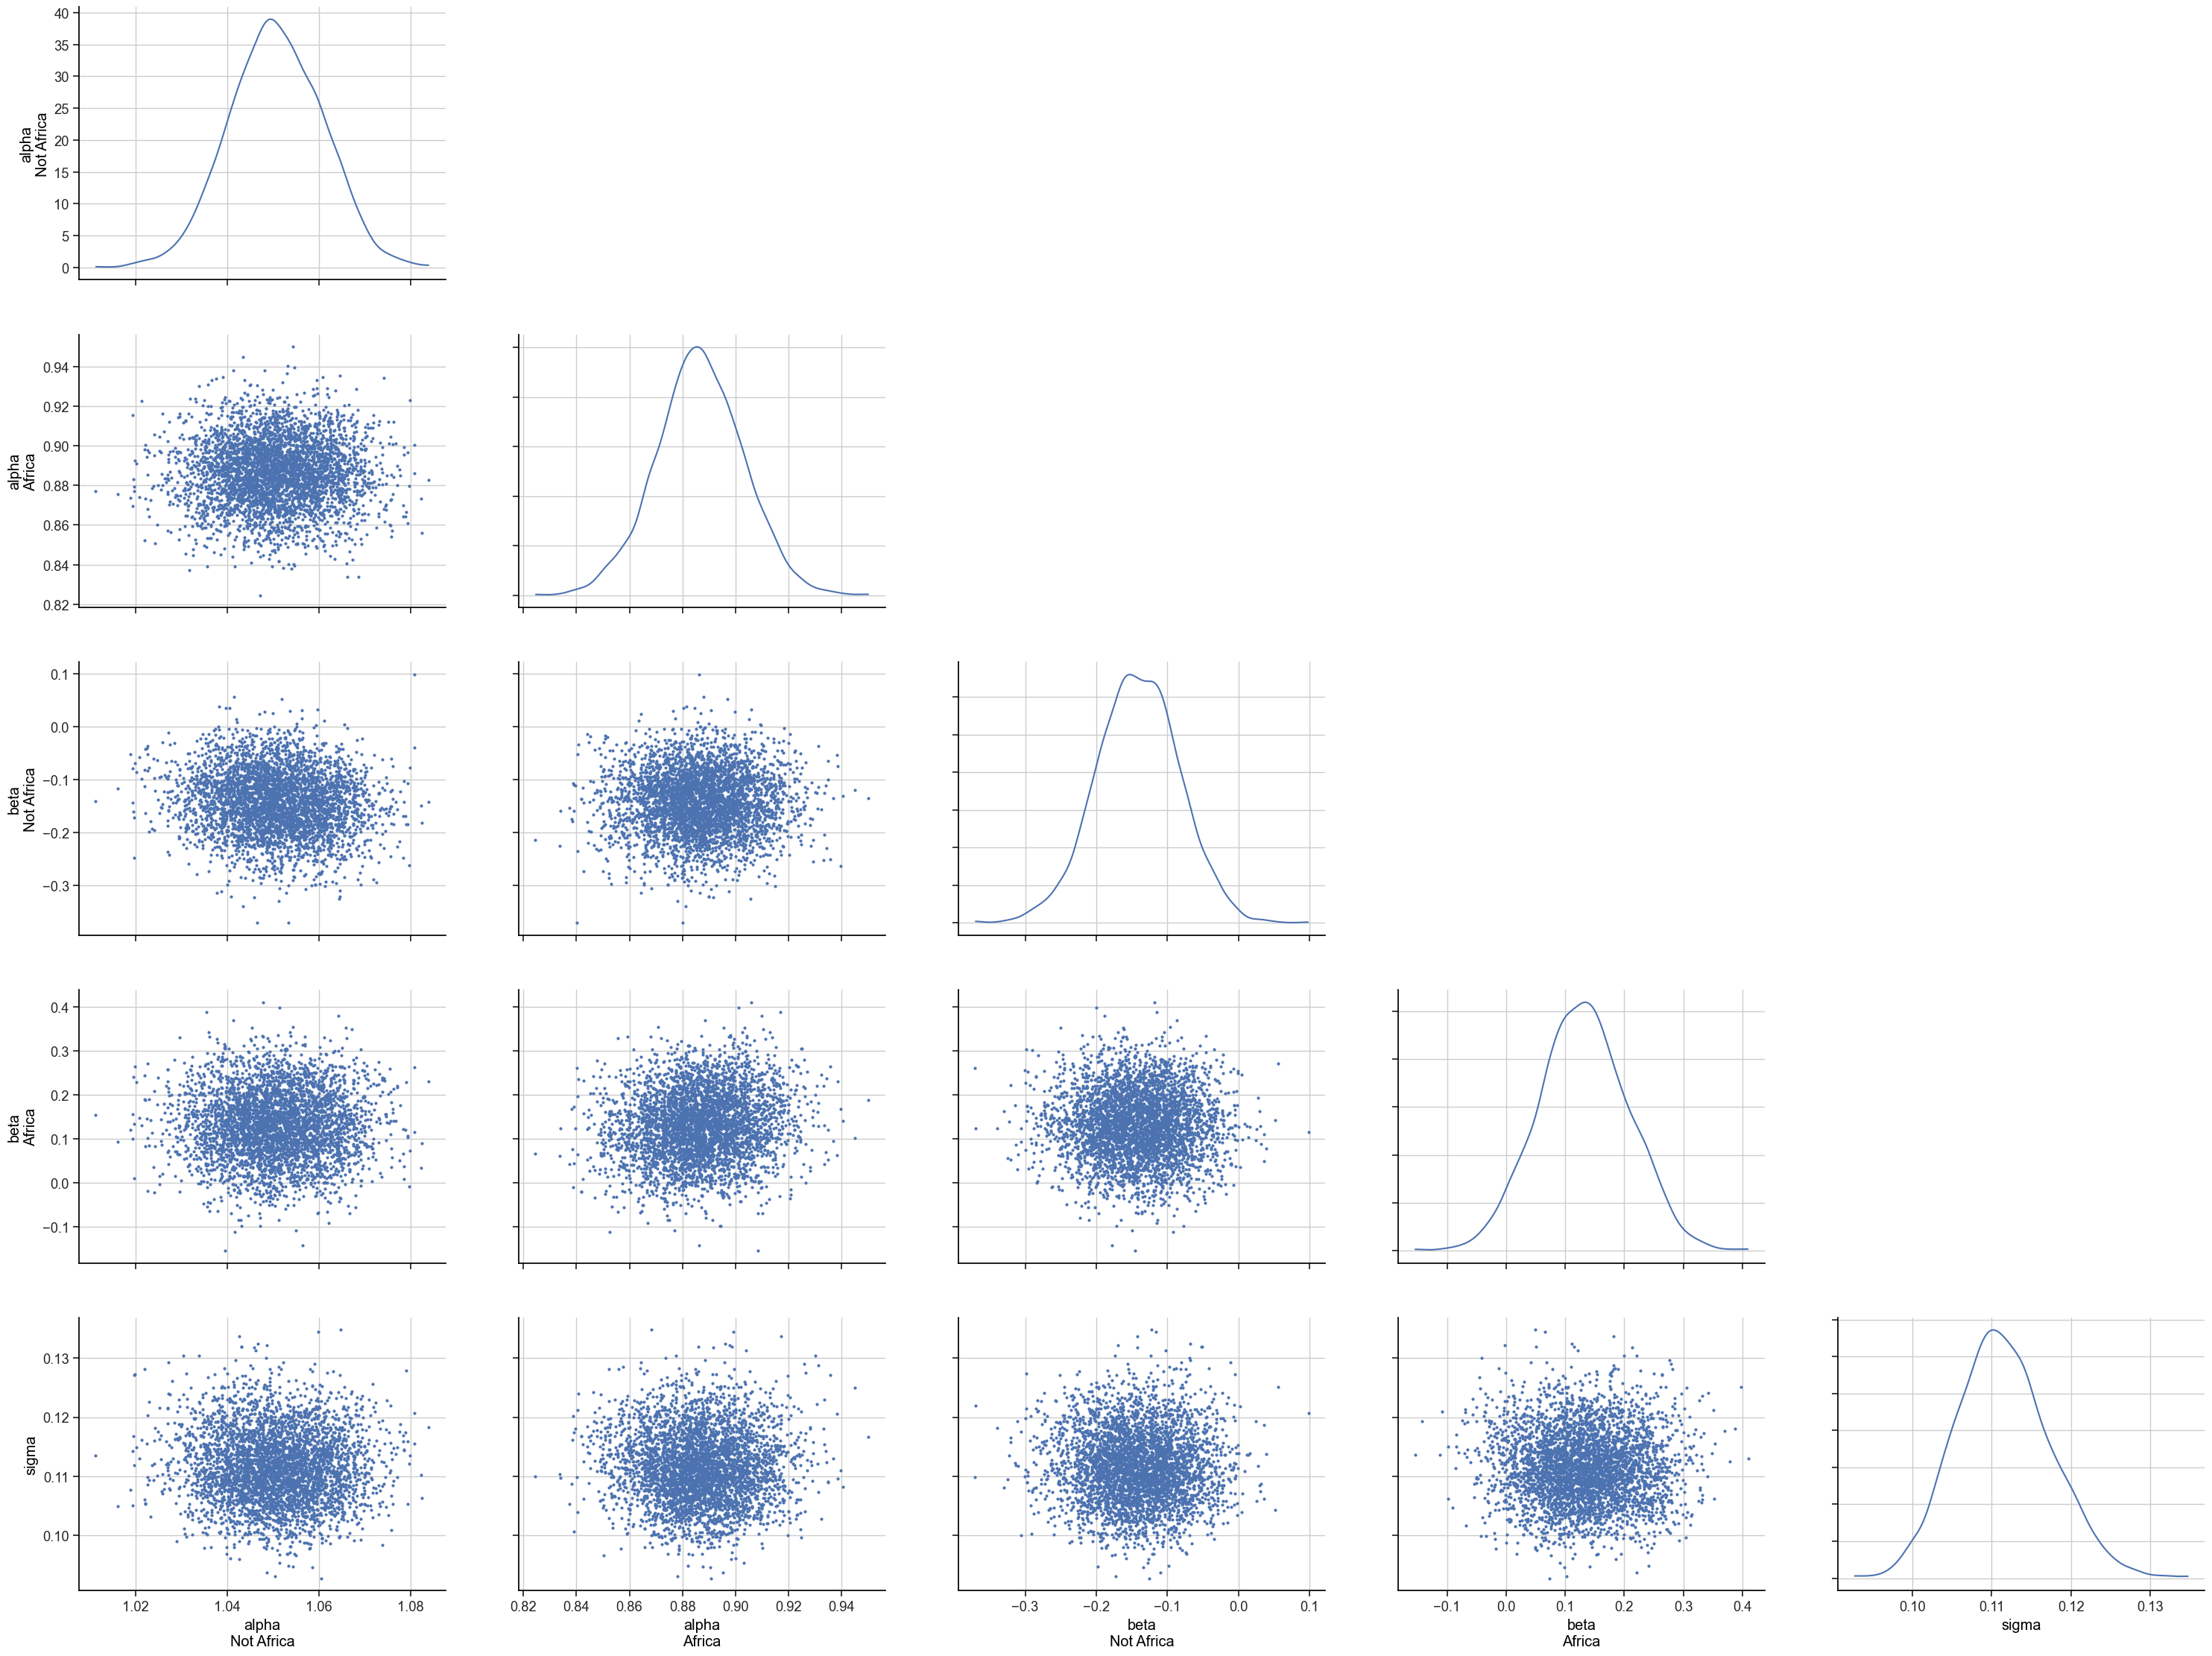

In [11]:
az.plot_pair(
    trace_9_1,
    var_names=["~mu"],
    marginals=True,
);

### 9.4.5 Checking the chain

Trace plot

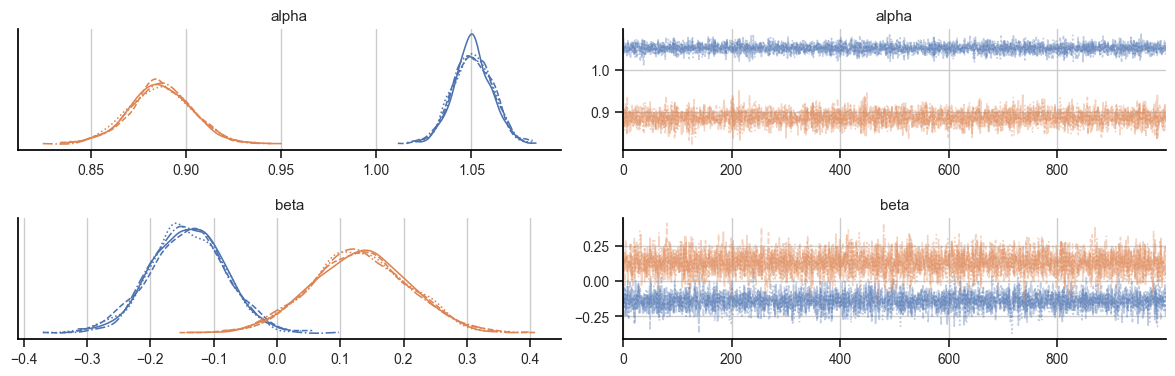

In [39]:
axs = az.plot_trace(
    trace_9_1,
    var_names=["alpha", "beta"],
)
axs.ravel()[0].get_figure().tight_layout()

Rank plot

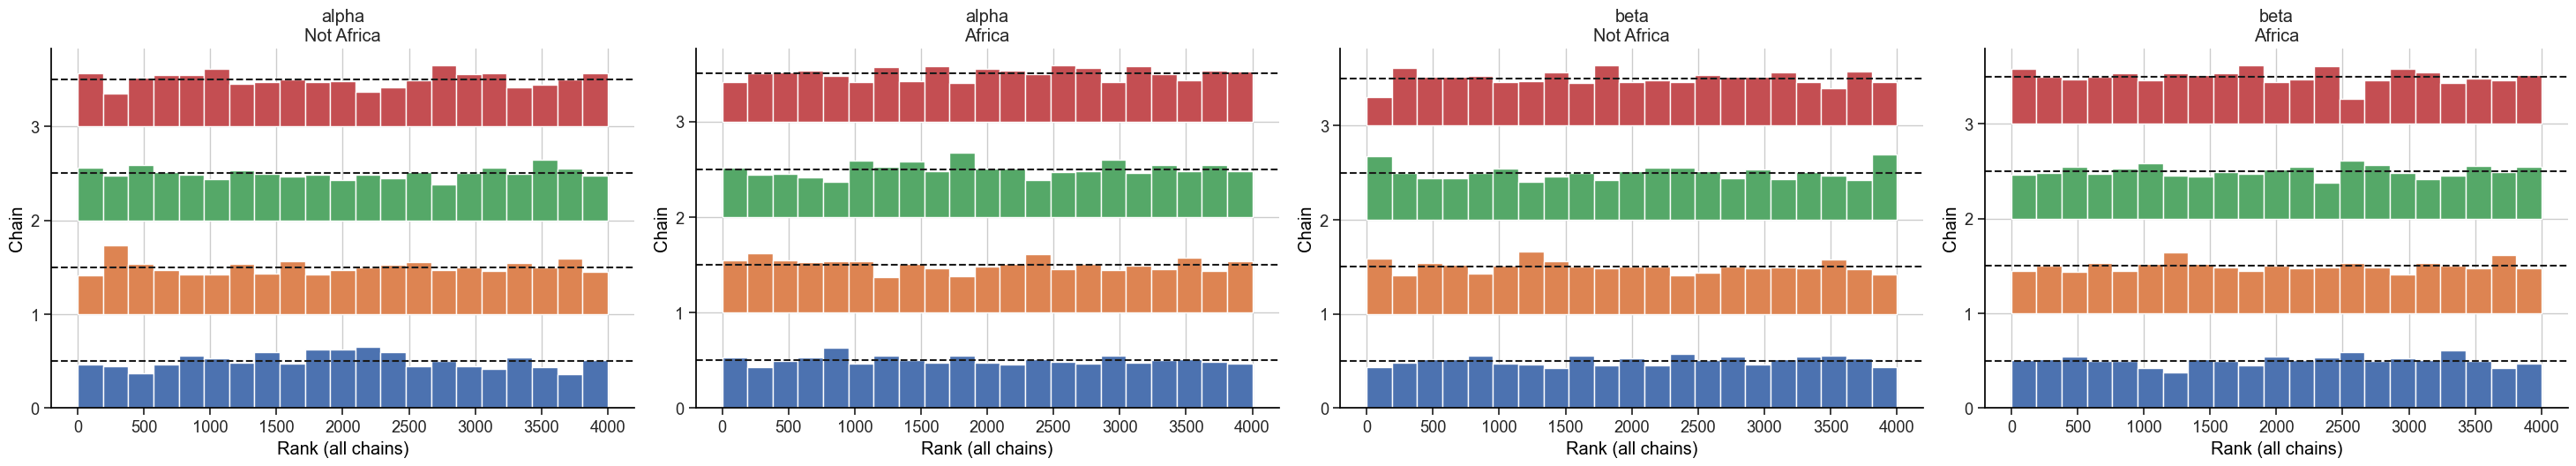

In [38]:
axs = az.plot_rank(
    trace_9_1,
    var_names=["alpha", "beta"],
)
axs.ravel()[0].get_figure().tight_layout()

## 9.5 Care and feeding of your Markov chain

### 9.5.3 Taming a wild chain

In [143]:
y = np.array([-1, 1])

with pm.Model() as m9_2:
    alpha = pm.Normal("alpha", mu=0, sigma=1000)
    sigma = pm.Exponential("sigma", lam=0.0001)

    pm.Normal("y", mu=alpha, sigma=sigma, observed=y)

    trace_9_2 = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 748 divergences after tuning. Increase `target_accept` or reparameterize.


In [59]:
az.summary(
    trace_9_2,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-36.764,349.154,-960.291,550.020,12.866,12.547,850.0,672.0,1.09
sigma,657.498,1334.009,19.711,2383.257,91.531,64.811,16.0,10.0,1.18


Note the small effective sample size and $\hat{R} > 1$.

Often, increasing `target_accept` can help convergence.

Let's have a look at a pair plot

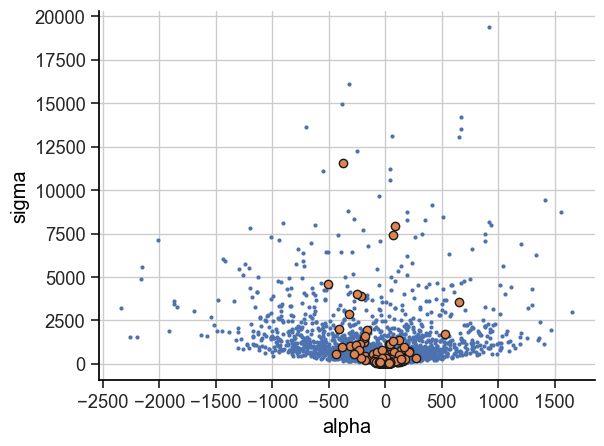

In [68]:
az.plot_pair(
    trace_9_2,
    divergences=True,
);

Yeah, that's pretty wild.

Putting sigma on a log scale makes it easier to see the pattern in the divergences.

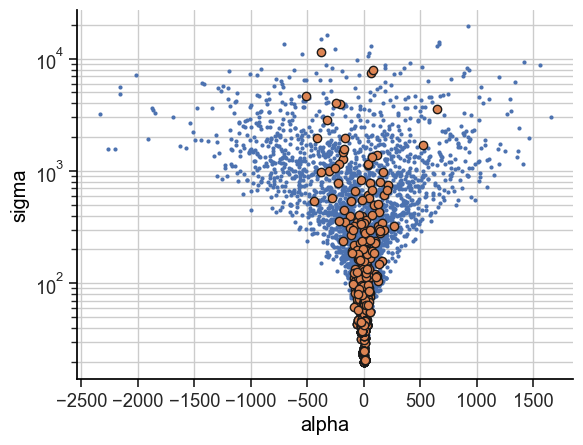

In [71]:
ax = az.plot_pair(
    trace_9_2,
    divergences=True,
)
ax.set(yscale="log");

Now let's inspect the trace plot

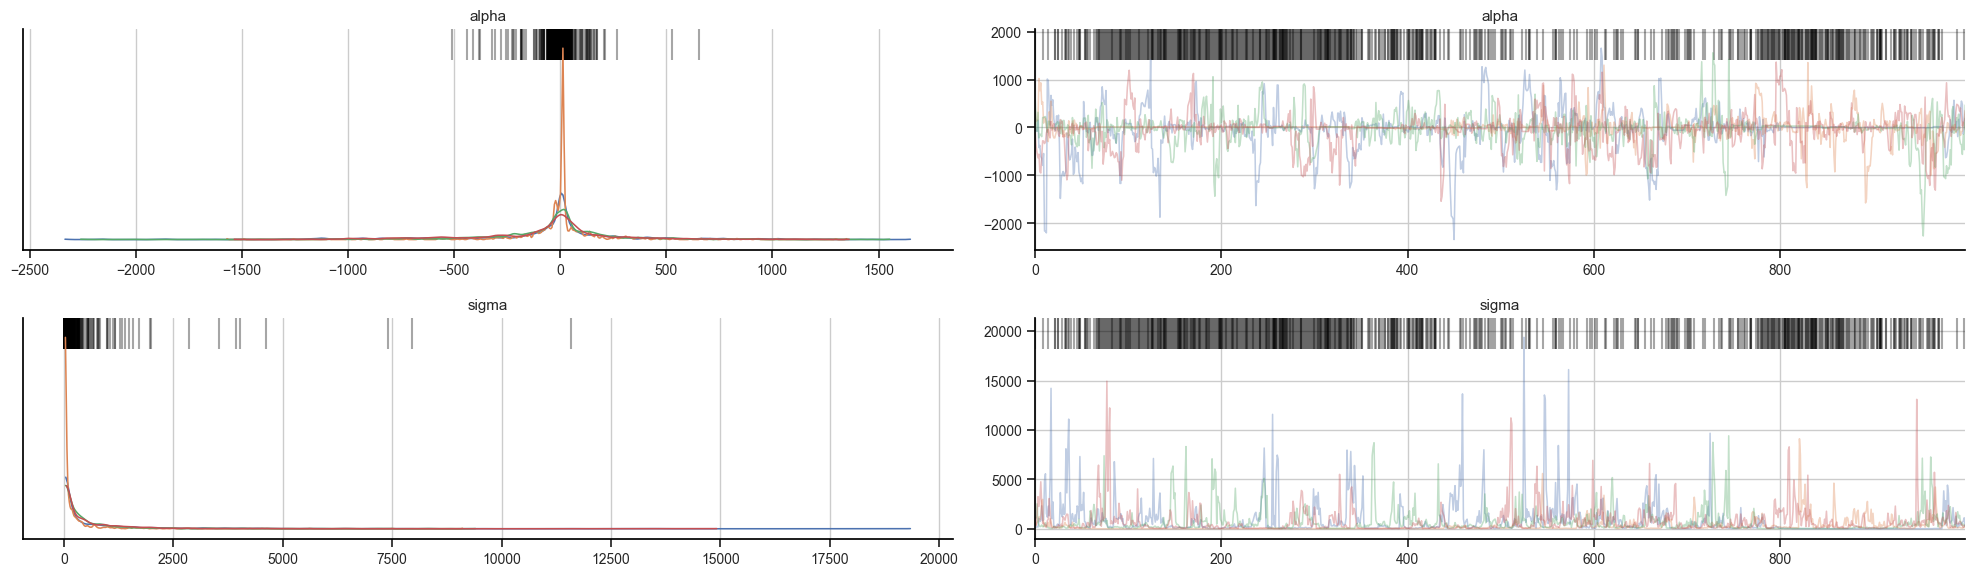

In [102]:
axs = az.plot_trace(
    trace_9_2,
    compact=False,  # makes different chains different colours
    divergences="top",
    figsize=(20, 6),
)
axs.ravel()[0].get_figure().tight_layout();

It's a bit janky, but we can get rid of the distributions and focus on the trace plots

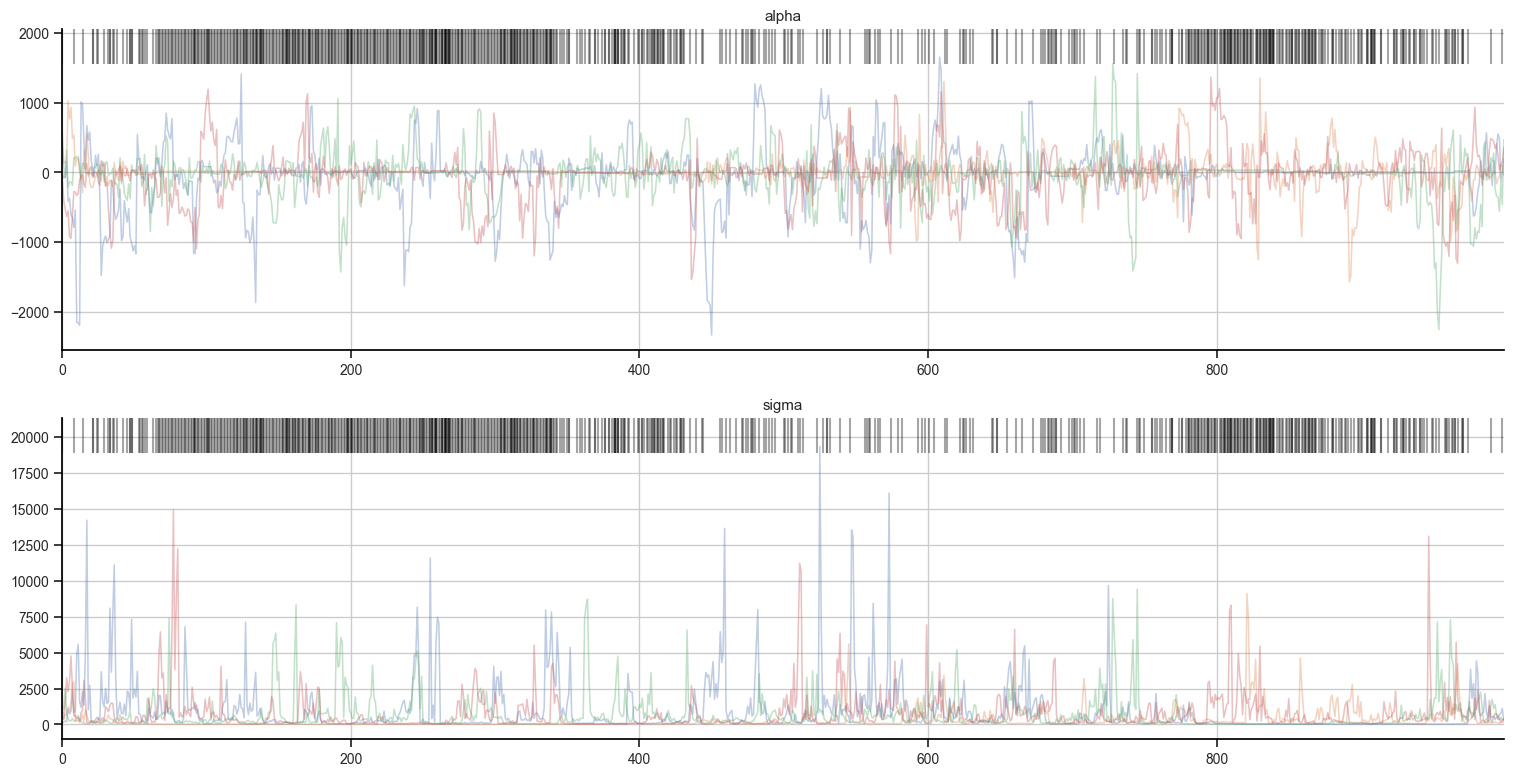

In [110]:
axs = az.plot_trace(
    trace_9_2,
    compact=False,  # makes different chains different colours
    divergences="top",
    figsize=(30, 8),
)
fig = axs.ravel()[0].get_figure()

axs[0, 0].remove()
axs[1, 0].remove()

fig.tight_layout();

Here it's very clear how the different chains are diverging and each chain drifts around and spikes.

We can also look at a Trank plot

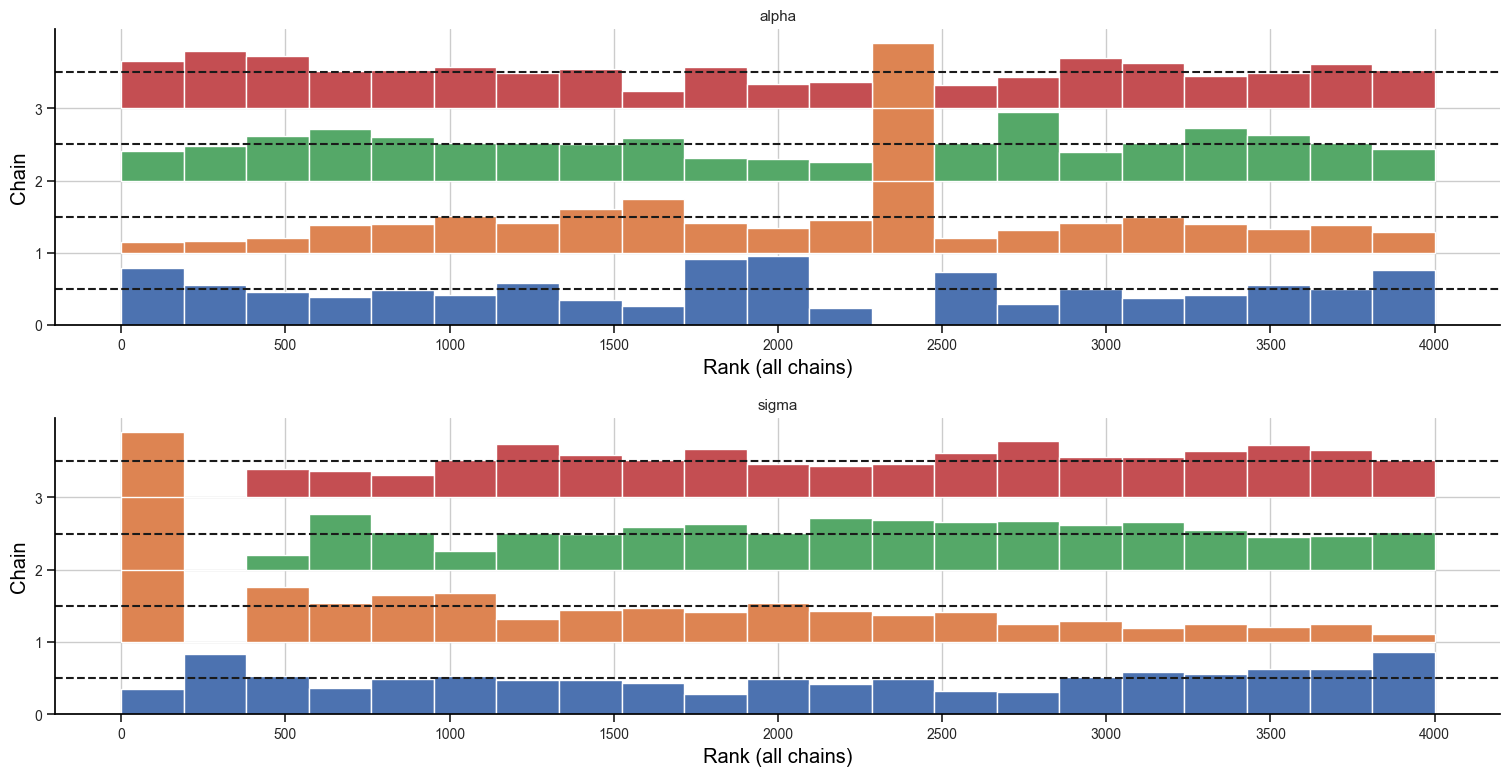

In [116]:
axs = az.plot_trace(
    trace_9_2,
    kind="rank_bars",
    compact=False,
    figsize=(30, 8),
)
fig = axs.ravel()[0].get_figure()

axs[0, 0].remove()
axs[1, 0].remove()

fig.tight_layout();

Notice how much variation there is between chains.

We can fix this by using weakly informative priors.

In [121]:
y = np.array([-1, 1])

with pm.Model() as m9_3:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    pm.Normal("y", mu=alpha, sigma=sigma, observed=y)

    trace_9_3 = pm.sample(
        target_accept=0.95,  # needed to avoid divergences
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [122]:
az.summary(
    trace_9_3,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.025,1.195,-2.070,2.537,0.036,0.028,1239.0,1066.0,1.0
sigma,1.554,0.821,0.489,3.084,0.024,0.017,1176.0,1671.0,1.0


The convergence stats looks much more healthy, so let's look at the trace plots.

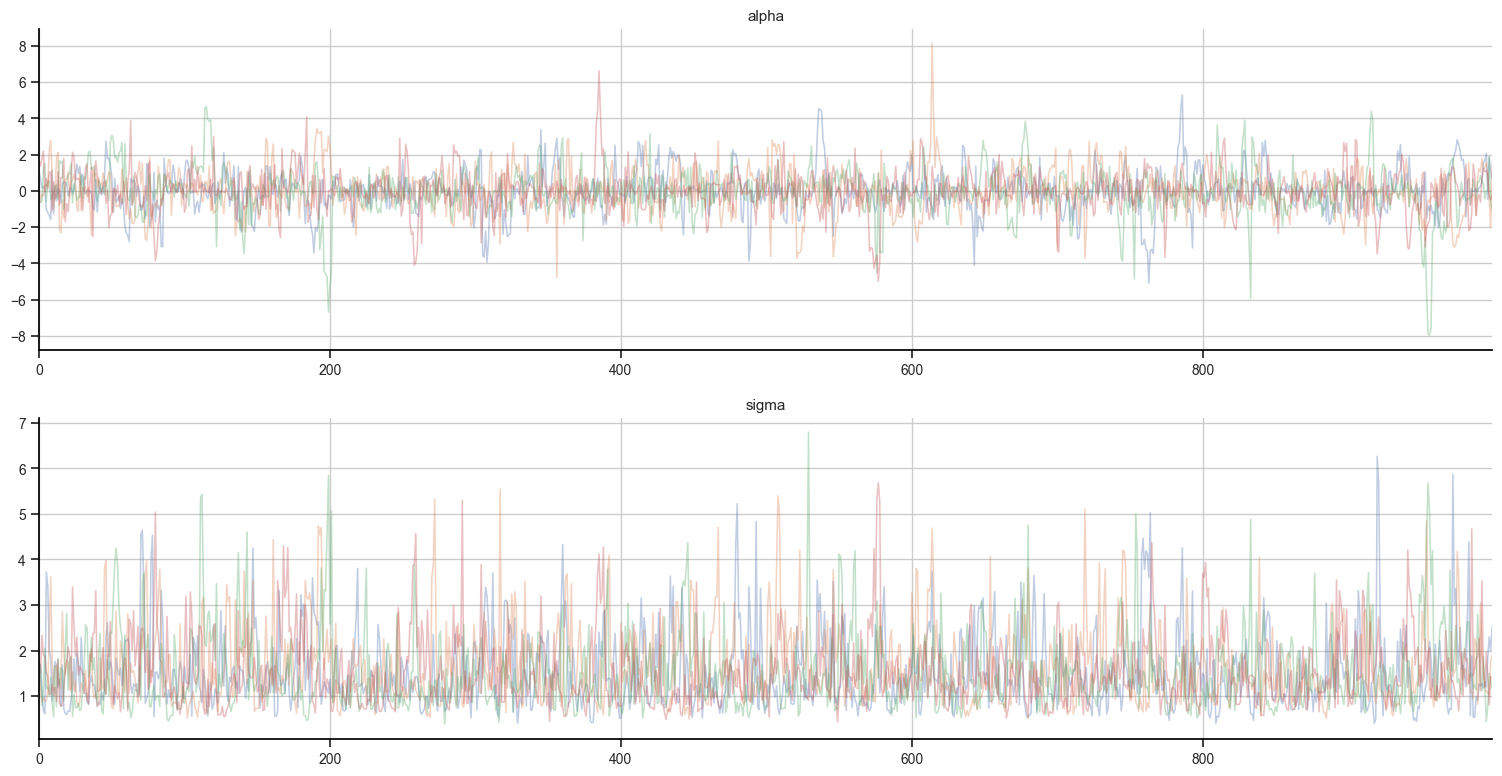

In [123]:
axs = az.plot_trace(
    trace_9_3,
    compact=False,  # makes different chains different colours
    divergences="top",
    figsize=(30, 8),
)
fig = axs.ravel()[0].get_figure()

axs[0, 0].remove()
axs[1, 0].remove()

fig.tight_layout();

Here it's very clear how the different chains are diverging and each chain drifts around and spikes.

We can also look at a Trank plot

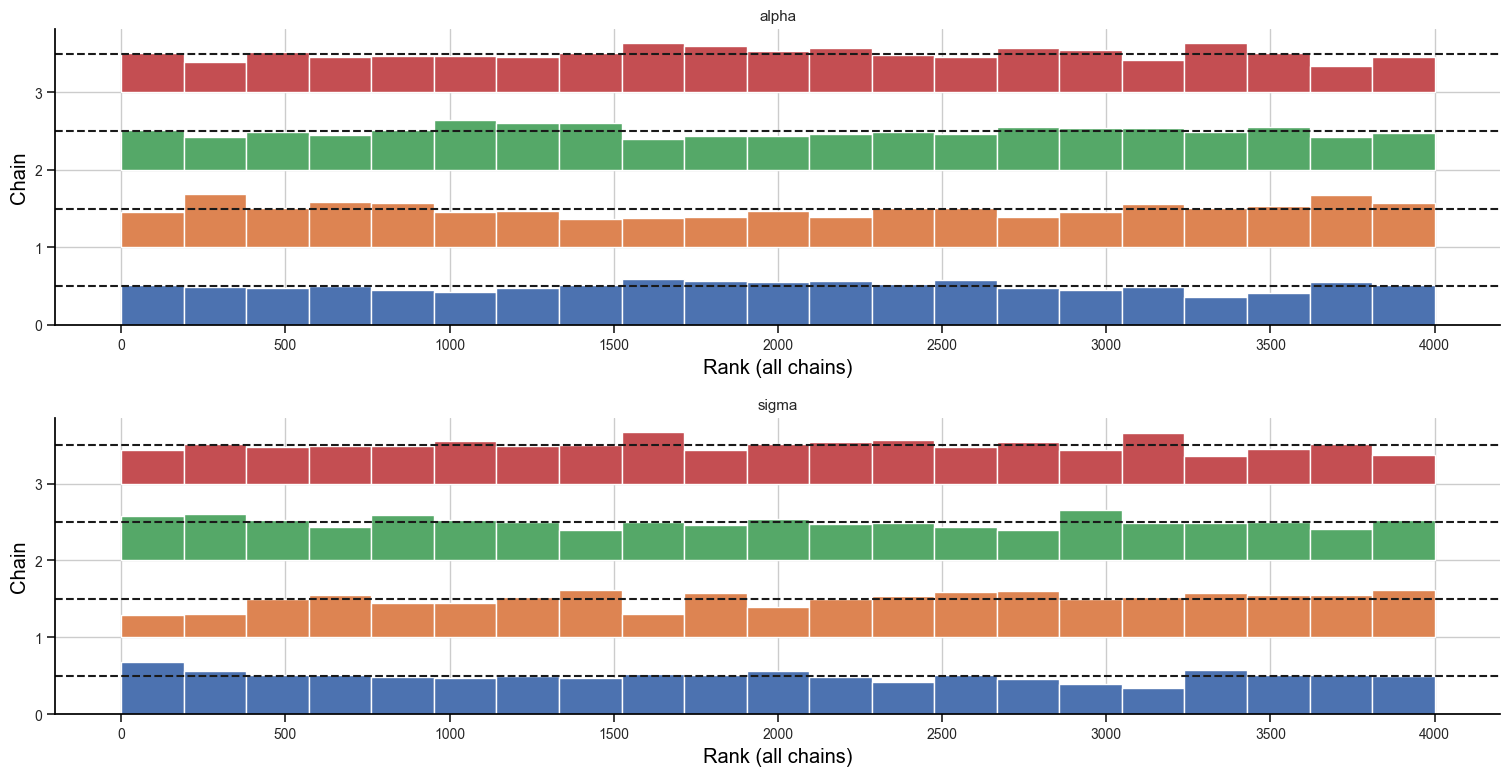

In [124]:
axs = az.plot_trace(
    trace_9_3,
    kind="rank_bars",
    compact=False,
    figsize=(30, 8),
)
fig = axs.ravel()[0].get_figure()

axs[0, 0].remove()
axs[1, 0].remove()

fig.tight_layout();

### 9.5.4 Non-identifiable parameters

In [144]:
y = rng.normal(0, 1, size=100)

with pm.Model() as m9_4:
    alpha1 = pm.Normal("alpha1", mu=0, sigma=1000)
    alpha2 = pm.Normal("alpha2", mu=0, sigma=1000)
    sigma = pm.Exponential("sigma", lam=1)

    mu = alpha1 + alpha2

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace_9_4 = pm.sample(
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, alpha2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 989 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [139]:
az.summary(
    trace_9_4,
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha1,514.241,551.997,-360.400,1183.044,260.644,198.540,6.0,33.0,1.96
alpha2,-514.290,552.001,-1183.030,360.287,260.646,198.542,6.0,33.0,1.96
sigma,1.044,0.057,0.932,1.143,0.016,0.011,15.0,101.0,1.23


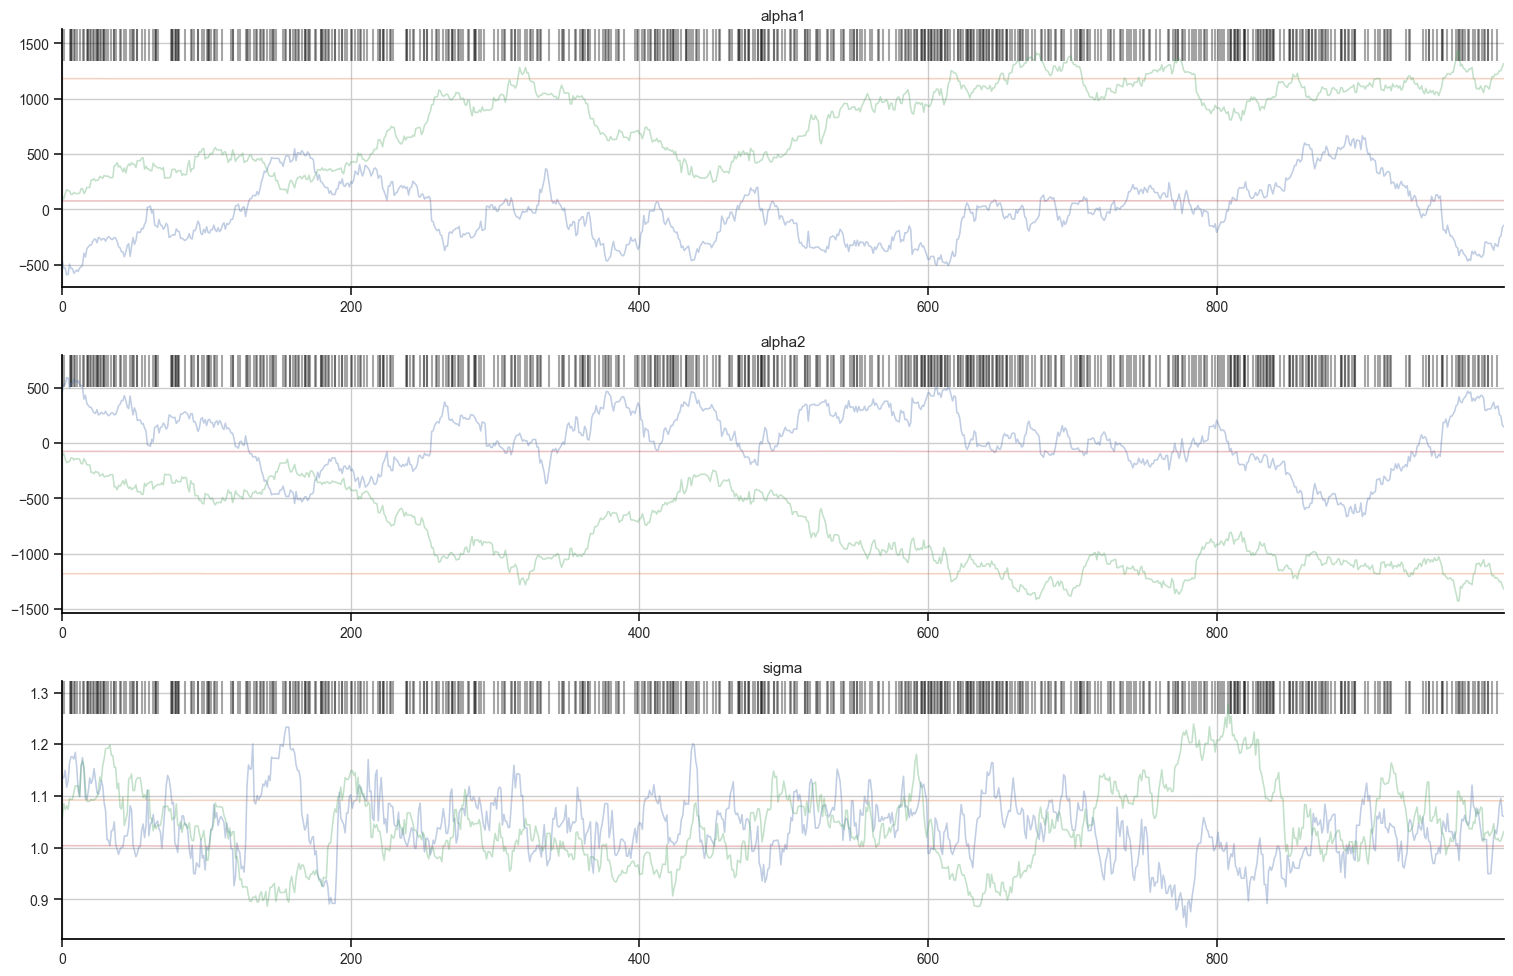

In [140]:
axs = az.plot_trace(
    trace_9_4,
    compact=False,  # makes different chains different colours
    divergences="top",
    figsize=(30, 10),
)
fig = axs.ravel()[0].get_figure()

for ax in axs[:, 0]:
    ax.remove()

fig.tight_layout();

The interesting thing here is that the chains in `alpha1` and `alpha2` appear to be highly correlated.

A pair plot is also very informative

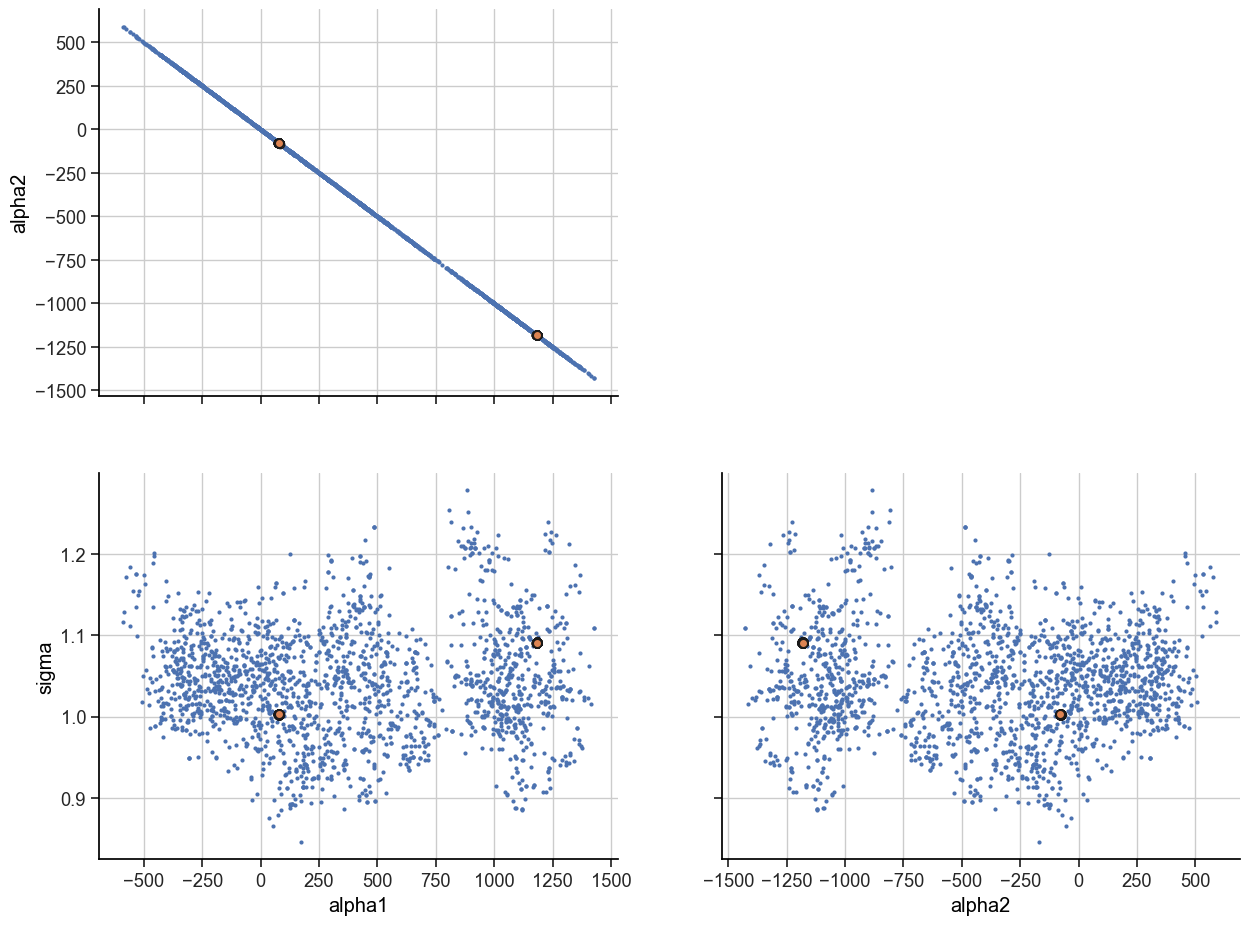

In [141]:
az.plot_pair(
    trace_9_4,
    divergences=True,
);

We can fix this with weakly informative priors.

In [ ]:
with pm.Model() as m9_5:
    alpha1 = pm.Normal("alpha1", mu=0, sigma=10)
    alpha2 = pm.Normal("alpha2", mu=0, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    mu = alpha1 + alpha2

    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace_9_5 = pm.sample(
        target_accept=0.95,
        random_seed=RANDOM_SEED,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha1, alpha2, sigma]


In [ ]:
az.summary(
    trace_9_5,
)

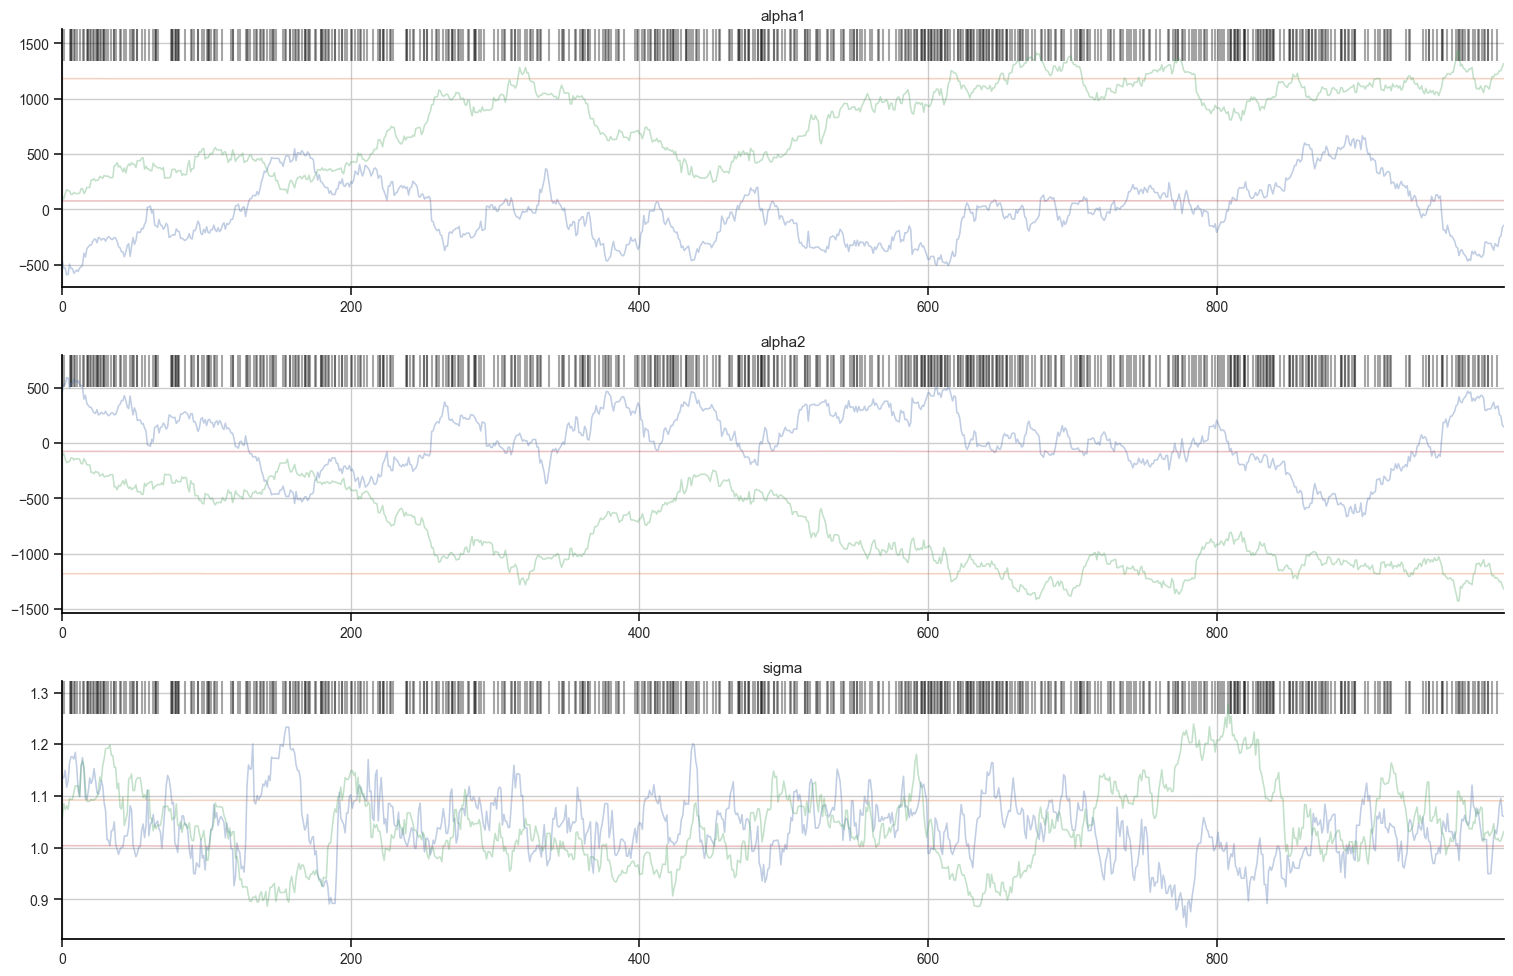

In [140]:
axs = az.plot_trace(
    trace_9_5,
    compact=False,  # makes different chains different colours
    divergences="top",
    figsize=(30, 10),
)
fig = axs.ravel()[0].get_figure()

for ax in axs[:, 0]:
    ax.remove()

fig.tight_layout();

The interesting thing here is that the chains in `alpha1` and `alpha2` appear to be highly correlated.

A pair plot is also very informative

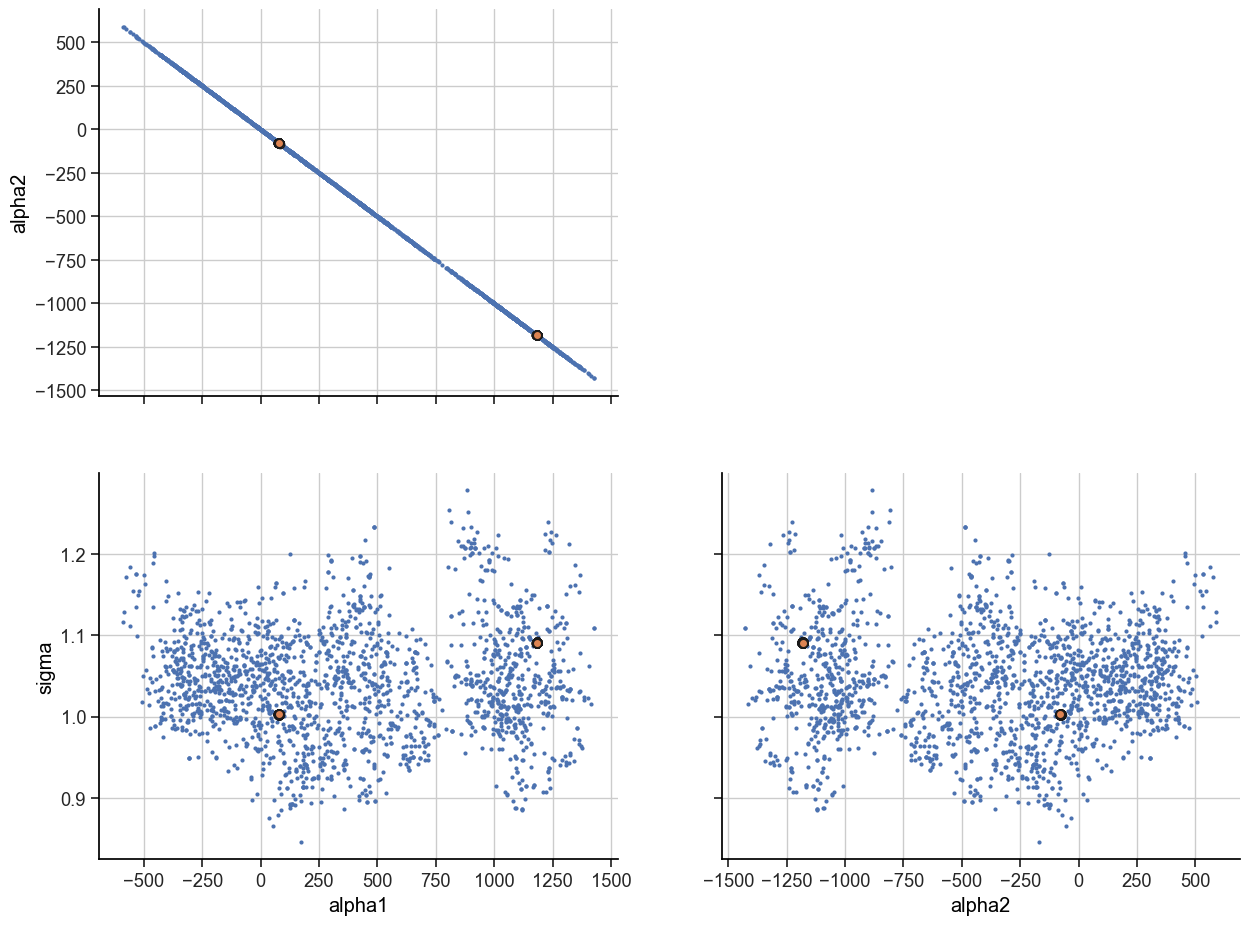

In [141]:
az.plot_pair(
    trace_9_5,
    divergences=True,
);